In [4]:
import pandas as pd
import os

data = pd.read_csv(os.getcwd()+'/data/BNP_data/train.csv')

The code below was taken from https://www.kaggle.com/cbrogan/titanic/xgboost-example-python/code. It fills numeric NaN values with the median, and non-numeric with the mode.

In [5]:
from sklearn.base import TransformerMixin
import numpy as np

class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
data = DataFrameImputer().fit_transform(data)

In [6]:
from sklearn import preprocessing

criteria = data.dtypes == object
object_columns = data[criteria.index[criteria]].columns

le = preprocessing.LabelEncoder()
for col in object_columns:
    data[col] = le.fit_transform(data[col])

data.head()


,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,2,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,21,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,1.469550,7.023803,2,4.205991,9.191265,2.412790,2.452166,2.301630,...,6.749117,2.739239,0.598896,6,1.614802,2.963620,1.957825,0,1.560138,1.589403
2,5,1,0.943877,5.310079,2,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,5,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,2,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,64,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,1.469550,7.023803,2,4.205991,8.670867,2.412790,2.452166,0.386032,...,6.749117,2.739239,0.139864,89,1.614802,2.963620,1.798436,0,1.560138,1.589403


In [8]:
from sklearn import cross_validation
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(data.drop('target', axis=1), data['target'], \
    test_size=0.33, random_state=5)

XGBOOST

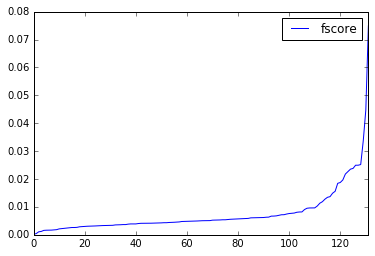

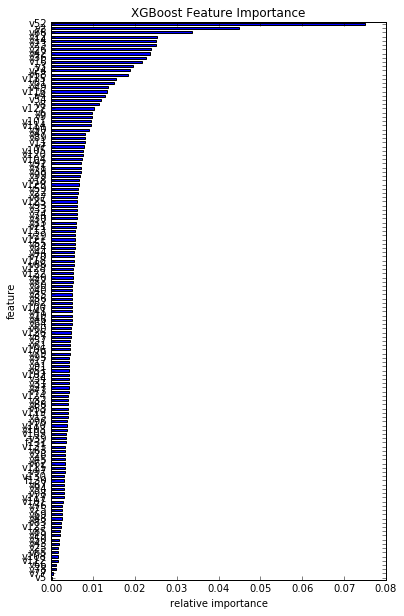

In [53]:
# Feature map is used to track (and plot) feature importance
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
    
create_feature_map(list(X_train.columns[2:]))

import xgboost as xgb
import operator

xgb_params = {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 6, 'seed': 42, 'eval_metric': 'logloss'}
num_rounds = 1000

dtrain = xgb.DMatrix(X_train, label = Y_train)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

importance = gbdt.get_fscore(fmap = 'xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
# gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train_mat, Y_train)
# predictions = gbm.predict(X_test_mat)

In [59]:
dtest = xgb.DMatrix(X_test, label = Y_test)
Y_test_pred = gbdt.predict(dtest)
Y_test_pred[Y_test_pred > 1] = 1
Y_test_pred[Y_test_pred < 0] = 0

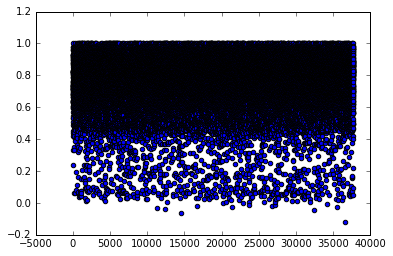

In [66]:
from matplotlib import pylab as plt

plt.scatter(range(len(Y_test_pred)), Y_test_pred)
plt.show()

In [75]:
def logloss(y, p):
    N = len(y)
    if len(p) != N:
        return print('Vectors of unequal length')
    
    p = np.array([max(min(p_i, 1-10**(-15)), 10**(-15)) for p_i in p])
    
    summand = y*np.log(p)+(1-y)*np.log(1-p)
    ll = -sum(summand)/N
    return ll


In [76]:
logloss(Y_test, Y_test_pred)

0.4702345006512258